# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
import pickle
from tqdm import tqdm
import os

# from plotly import plotly
# import plotly.offline as offline
# import plotly.graph_objs as go
# offline.init_notebook_mode()
from collections import Counter

In [2]:
import pandas
data = pandas.read_csv('preprocessed_data.csv',nrows = 50000)
data.head(3)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


In [3]:

y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


<h2>1.2 Splitting data into Train and Test: Stratified Sampling</h2>

In [5]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
#We have added “stratify” argument to the y component of the original dataset. This will be used by the train_test_split() function to ensure that both the train and test sets have the proportion of examples in each class that is present in the provided “y” array.
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)


# BOW Featurization

<h2>1.3 Make Data Model Ready: encoding essay(BOW)</h2>

In [6]:
#Encoding Essay

vectorizer_essay_bow = CountVectorizer(min_df=10,ngram_range=(1,4),max_features=50000)
vectorizer_essay_bow.fit(X_train['essay'].values) #Fit has to be done only in train data

# print(vectorizer_essay_bow.transform(X_train['essay'].values).toarray())
print(len(vectorizer_essay_bow.get_feature_names()))
X_train_essay_bow = vectorizer_essay_bow.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer_essay_bow.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)



50000
After vectorizations
(33500, 50000) (33500,)
(16500, 50000) (16500,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features(BOW)</h2>

In [7]:
#Categorical Features

#Encoding Teacher Prefix

vectorizer_teacher_prefix = CountVectorizer()
vectorizer_teacher_prefix.fit(X_train['teacher_prefix'].values)
X_train_teacher_prefix_bow = vectorizer_teacher_prefix.transform(X_train['teacher_prefix'].values)
X_test_teacher_prefix_bow = vectorizer_teacher_prefix.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_prefix_bow.shape, y_train.shape)
print(X_test_teacher_prefix_bow.shape, y_test.shape)
print("="*100)

#Encoding Project Grade Category

vectorizer_grade = CountVectorizer()
vectorizer_grade.fit(X_train['project_grade_category'].values)
X_train_project_grade_category_bow = vectorizer_grade.transform(X_train['project_grade_category'].values)
X_test_project_grade_category_bow = vectorizer_grade.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_project_grade_category_bow.shape, y_train.shape)
print(X_test_project_grade_category_bow.shape, y_test.shape)
print("="*100)

#Encoding School State

vectorizer_state = CountVectorizer()
vectorizer_state.fit(X_train['school_state'].values)
X_train_school_state_bow = vectorizer_state.transform(X_train['school_state'].values)
X_test_school_state_bow = vectorizer_state.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_school_state_bow.shape, y_train.shape)
print(X_test_school_state_bow.shape, y_test.shape)
print("="*100)

#Encoding Clean Categories

vectorizer_clean_categories = CountVectorizer()
vectorizer_clean_categories.fit(X_train['clean_categories'].values)
X_train_clean_categories_bow = vectorizer_clean_categories.transform(X_train['clean_categories'].values)
X_test_clean_categories_bow = vectorizer_clean_categories.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_categories_bow.shape, y_train.shape)
print(X_test_clean_categories_bow.shape, y_test.shape)
print("="*100)

#Encoding Clean Subcategories
vectorizer_clean_subcategories = CountVectorizer()
vectorizer_clean_subcategories.fit(X_train['clean_subcategories'].values)
X_train_clean_subcategories_bow = vectorizer_clean_subcategories.transform(X_train['clean_subcategories'].values)
X_test_clean_subcategories_bow = vectorizer_clean_subcategories.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_subcategories_bow.shape, y_train.shape)
print(X_test_clean_subcategories_bow.shape, y_test.shape)
print("="*100)



After vectorizations
(33500, 5) (33500,)
(16500, 5) (16500,)
After vectorizations
(33500, 4) (33500,)
(16500, 4) (16500,)
After vectorizations
(33500, 51) (33500,)
(16500, 51) (16500,)
After vectorizations
(33500, 9) (33500,)
(16500, 9) (16500,)
After vectorizations
(33500, 30) (33500,)
(16500, 30) (16500,)


In [8]:
#Vectorizing Price

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))


X_train_price_norm_reshape = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm_reshape = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

print("After Reshape")

print(X_train_price_norm_reshape.shape, y_train.shape)
print(X_test_price_norm_reshape.shape, y_test.shape)

After vectorizations
(1, 33500) (33500,)
(1, 16500) (16500,)
After Reshape
(33500, 1) (33500,)
(16500, 1) (16500,)


In [9]:
#Vectorizing Teacher Number Of Previously Posted Projects


from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)) #1 row and any number of columns

X_train_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_teacher_number_of_previously_posted_projects_norm_reshape = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacher_number_of_previously_posted_projects_norm_reshape = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

print("After Reshape")
print(X_train_teacher_number_of_previously_posted_projects_norm_reshape.shape, y_train.shape) 
print(X_test_teacher_number_of_previously_posted_projects_norm_reshape.shape, y_test.shape)
print("="*100)



After vectorizations
(1, 33500) (33500,)
(1, 16500) (16500,)
After Reshape
(33500, 1) (33500,)
(16500, 1) (16500,)


# Set 1 : categorical, numerical features + preprocessed_essay (BOW)

In [10]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow,X_train_teacher_prefix_bow,X_train_project_grade_category_bow,X_train_school_state_bow,X_train_clean_categories_bow,X_train_clean_subcategories_bow,X_train_price_norm_reshape,X_train_teacher_number_of_previously_posted_projects_norm_reshape)).tocsr()
X_te = hstack((X_test_essay_bow,X_test_teacher_prefix_bow,X_test_project_grade_category_bow,X_test_school_state_bow,X_test_clean_categories_bow,X_test_clean_subcategories_bow,X_test_price_norm_reshape,X_test_teacher_number_of_previously_posted_projects_norm_reshape)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 50101) (33500,)
(16500, 50101) (16500,)


# TFIDF Featurization

# Make Data Model Ready: encoding essay(TFIDF)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=50000) #Considering top 5000 features
vectorizer_tfidf.fit(X_train['essay'].values)

X_train_essay_tfidf = vectorizer_tfidf.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer_tfidf.transform(X_test['essay'].values)


print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)


After vectorizations
(33500, 50000) (33500,)
(16500, 50000) (16500,)


# Make Data Model Ready: encoding numerical, categorical features(TFIDF)

In [14]:
#Categorical Features

#Encoding Teacher Prefix
vectorizer_tfidf = TfidfVectorizer()
vectorizer_tfidf.fit(X_train['teacher_prefix'].values)
X_train_teacher_prefix_tfidf = vectorizer_tfidf.transform(X_train['teacher_prefix'].values)
X_test_teacher_prefix_tfidf = vectorizer_tfidf.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_prefix_tfidf.shape, y_train.shape)
print(X_test_teacher_prefix_tfidf.shape, y_test.shape)
print("="*100)

#Encoding Project Grade Category

vectorizer_tfidf.fit(X_train['project_grade_category'].values)
X_train_project_grade_category_tfidf = vectorizer_tfidf.transform(X_train['project_grade_category'].values)
X_test_project_grade_category_tfidf = vectorizer_tfidf.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_project_grade_category_tfidf.shape, y_train.shape)
print(X_test_project_grade_category_tfidf.shape, y_test.shape)
print("="*100)

#Encoding School State


vectorizer_tfidf.fit(X_train['school_state'].values)
X_train_school_state_tfidf = vectorizer_tfidf.transform(X_train['school_state'].values)
X_test_school_state_tfidf = vectorizer_tfidf.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_school_state_tfidf.shape, y_train.shape)
print(X_test_school_state_tfidf.shape, y_test.shape)
print("="*100)

#Encoding Clean Categories


vectorizer_tfidf.fit(X_train['clean_categories'].values)
X_train_clean_categories_tfidf = vectorizer_tfidf.transform(X_train['clean_categories'].values)
X_test_clean_categories_tfidf = vectorizer_tfidf.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_categories_tfidf.shape, y_train.shape)
print(X_test_clean_categories_tfidf.shape, y_test.shape)
print("="*100)

#Encoding Clean Subcategories
vectorizer_tfidf.fit(X_train['clean_subcategories'].values)
X_train_clean_subcategories_tfidf= vectorizer_tfidf.transform(X_train['clean_subcategories'].values)
X_test_clean_subcategories_tfidf = vectorizer_tfidf.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_subcategories_tfidf.shape, y_train.shape)
print(X_test_clean_subcategories_tfidf.shape, y_test.shape)
print("="*100)



After vectorizations
(33500, 5) (33500,)
(16500, 5) (16500,)
After vectorizations
(33500, 4) (33500,)
(16500, 4) (16500,)
After vectorizations
(33500, 51) (33500,)
(16500, 51) (16500,)
After vectorizations
(33500, 9) (33500,)
(16500, 9) (16500,)
After vectorizations
(33500, 30) (33500,)
(16500, 30) (16500,)



<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

Testing the performance of the model on test data, plotting ROC Curves

# Applying MultiNomial NB on BOW

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB


nb = MultinomialNB(fit_prior = False,class_prior=[0.5,0.5])

parameters = {'alpha':[0.00001, 0.0001,0.001, 0.01, 0.1,0.5,0.8, 1, 10,  100,  1000]}

clf = GridSearchCV(nb, parameters, cv= 3, scoring='roc_auc',return_train_score=True,verbose=2)

clf.fit(X_tr, y_train)
#converting the clf.cv_results to dataframe

results = pd.DataFrame.from_dict(clf.cv_results_)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
results.head(3)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... alpha=1e-05, total=   0.4s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ...................................... alpha=1e-05, total=   0.2s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.2s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.1s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.1s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.2s
[CV] alpha=0.001 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    8.1s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.156987,0.038511,0.079673,0.071603,1e-05,{'alpha': 1e-05},0.644192,0.646140,0.655632,0.648655,0.004997,9,0.956629,0.962245,0.960339,0.959738,0.002332
1,0.127731,0.030757,0.016331,0.001011,0.0001,{'alpha': 0.0001},0.653969,0.657984,0.668453,0.660135,0.006105,7,0.953151,0.959106,0.957223,0.956493,0.002485
2,0.140407,0.021567,0.017081,0.001035,0.001,{'alpha': 0.001},0.663459,0.668806,0.682008,0.671424,0.007796,6,0.948330,0.954645,0.952778,0.951918,0.002649


100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13565.82it/s]


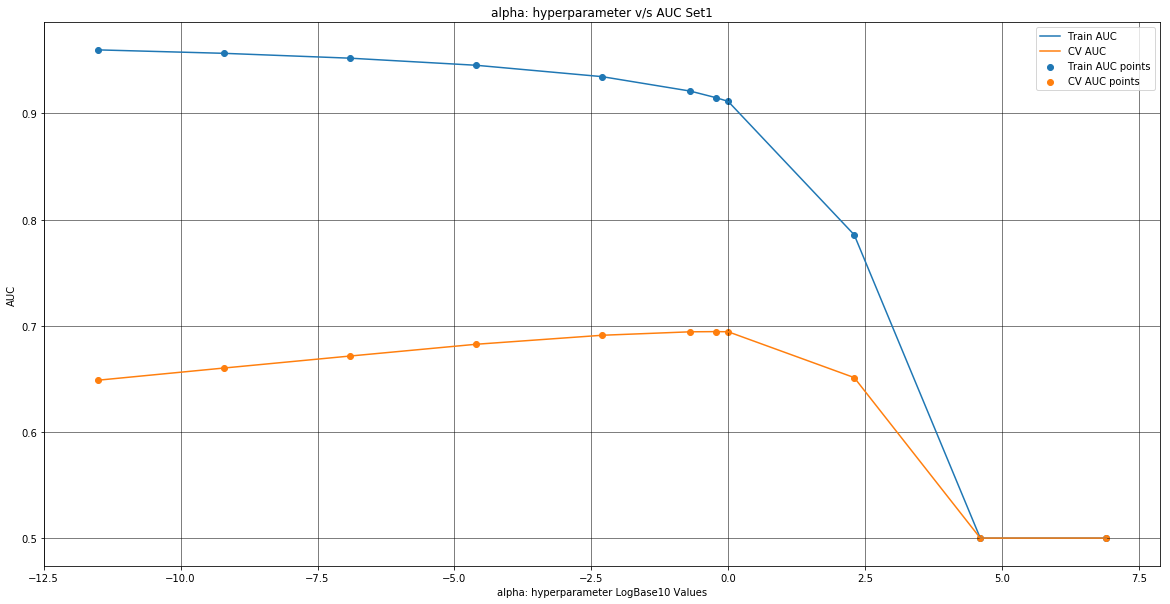

Best Hyperparameter(alpha) is 0.5


In [16]:
import math
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1,0.5,0.8, 1, 10,  100,  1000]
log_alphas =[]

for a in tqdm(alphas):
    b = math.log(a)
    log_alphas.append(b)

plt.figure(figsize=(20,10))

plt.plot(log_alphas, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(log_alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(log_alphas, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(log_alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter LogBase10 Values")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC Set1")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()
print("Best Hyperparameter(alpha) is",cv_auc[np.argmax(log_alphas)])

In [17]:
# To find the probability estimates if data point corresponds to 1/0 and probability estimates of class 1 is passed to roc_auc score
def predict_probability(clf, data):
 
    y_data_pred= clf.predict_proba(data)  
    
    return y_data_pred[:,1]

###### Best Hyperparameter = 0.5

AUC Score Train Data : 0.8770544328362238
AUC Score Test Data : 0.6911531245489969
[2.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.71692034e-66
 3.17169133e-76 4.89371776e-88]


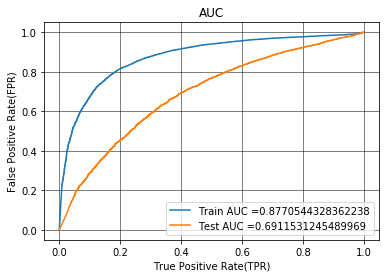

In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

from sklearn.metrics import roc_curve,roc_auc_score

nb_bow = MultinomialNB(alpha = 0.5,fit_prior =False,class_prior=[0.5,0.5])

nb_bow.fit(X_tr, y_train)

y_train_pred_prob = predict_probability(nb_bow, X_tr)    
y_test_pred_prob = predict_probability(nb_bow, X_te)



#Print Area Under Curve Scores(AUC Scores)

nb_auc_train = roc_auc_score(y_train,y_train_pred_prob)
nb_auc_test = roc_auc_score(y_test,y_test_pred_prob)
print("AUC Score Train Data :",nb_auc_train)
print("AUC Score Test Data :",nb_auc_test)

#Plot ROC Curve
# roc_curve(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
#If AUC curve if going through middle og grid then its dumb model.

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_prob)


test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_prob)
print(te_thresholds)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

# Confusion Matrix (Set1)



In [19]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [20]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_prob, best_t)))
print("Test confusion matrix")
Confusion_Matrix_Test_Data = confusion_matrix(y_test, predict_with_best_t(y_test_pred_prob, best_t))
print(Confusion_Matrix_Test_Data)#Need predicted values as 2nd parameter not probability values

the maximum value of tpr*(1-fpr) 0.654315753280474 for threshold 0.488
Train confusion matrix
[[ 4353  1012]
 [ 5446 22689]]
Test confusion matrix
[[ 1353  1289]
 [ 3329 10529]]


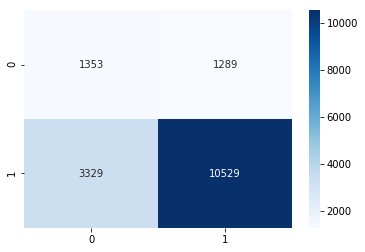

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt     

#annot -If True, write the data value in each cell
#fmt - String formatting code to use when adding annotations.If fmt is not there values come in expoential form(e)
sns.heatmap(Confusion_Matrix_Test_Data, annot=True,fmt ='d',cmap='Blues')


# Set 2 : categorical, numerical features + preprocessed_essay (TFIDF)


In [22]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf,X_train_teacher_prefix_tfidf,X_train_project_grade_category_tfidf,X_train_school_state_tfidf,X_train_clean_categories_tfidf,X_train_clean_subcategories_tfidf,X_train_price_norm_reshape,X_train_teacher_number_of_previously_posted_projects_norm_reshape)).tocsr()
X_te = hstack((X_test_essay_tfidf,X_test_teacher_prefix_tfidf,X_test_project_grade_category_tfidf,X_test_school_state_tfidf,X_test_clean_categories_tfidf,X_test_clean_subcategories_tfidf,X_test_price_norm_reshape,X_test_teacher_number_of_previously_posted_projects_norm_reshape)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)



Final Data matrix
(33500, 50101) (33500,)
(16500, 50101) (16500,)


# Applying MultiNomial NB on TFIDF

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB


nb = MultinomialNB(fit_prior =False, class_prior=[0.5,0.5])

parameters = {'alpha':[0.00001, 0.0001,0.001, 0.01, 0.1,0.5,0.8, 1, 10,  100,  1000]}

clf = GridSearchCV(nb, parameters, cv= 3, scoring='roc_auc',return_train_score=True,verbose=2)

clf.fit(X_tr, y_train)
#converting the clf.cv_results to dataframe

results = pd.DataFrame.from_dict(clf.cv_results_)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
results.head(3)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... alpha=1e-05, total=   0.3s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.2s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.2s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.2s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.3s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.2s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.3s
[CV] alpha=0.01 ......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    8.2s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.145857,0.046735,0.032165,0.013943,1e-05,{'alpha': 1e-05},0.646284,0.647525,0.662717,0.652175,0.007471,6,0.964527,0.968367,0.966567,0.966487,0.001569
1,0.184490,0.005039,0.032377,0.007883,0.0001,{'alpha': 0.0001},0.653015,0.656267,0.671406,0.660229,0.008014,4,0.960551,0.964858,0.962898,0.962769,0.001760
2,0.205725,0.015414,0.043343,0.008891,0.001,{'alpha': 0.001},0.660226,0.665865,0.681168,0.669086,0.008848,3,0.954497,0.959343,0.957246,0.957029,0.001985


100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11064.11it/s]


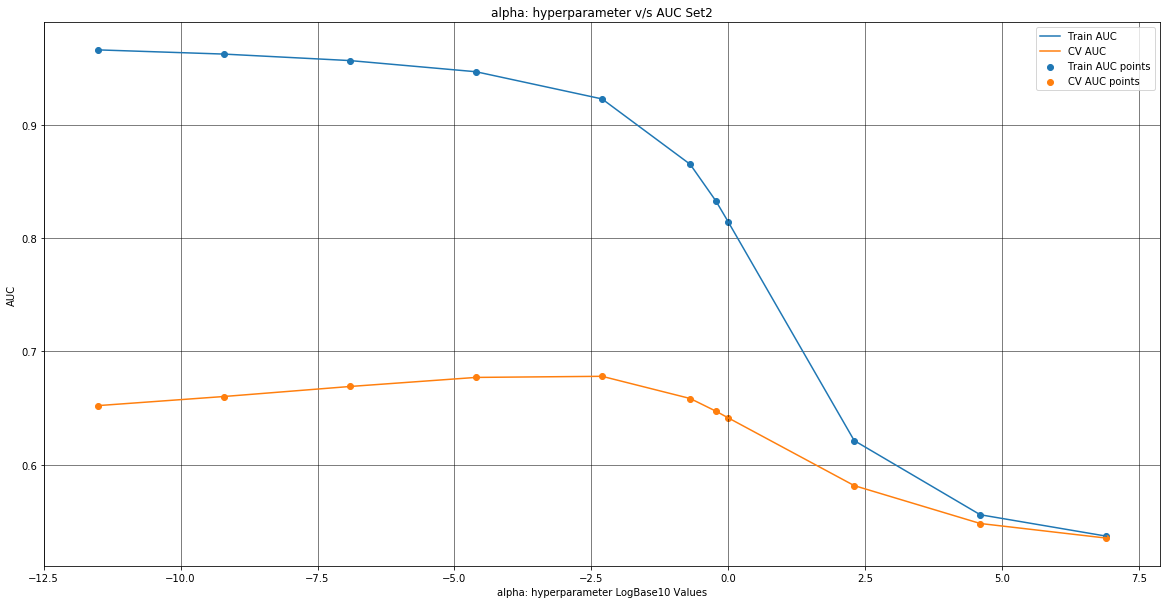

Best Hyperparameter(alpha) is 0.535136191991345


In [24]:
import math
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1,0.5,0.8, 1, 10,  100,  1000]
log_alphas =[]

for a in tqdm(alphas):
    b = math.log(a)
    log_alphas.append(b)

plt.figure(figsize=(20,10))

plt.plot(log_alphas, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039

plt.plot(log_alphas, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter LogBase10 Values")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC Set2")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()
print("Best Hyperparameter(alpha) is",cv_auc[np.argmax(log_alphas)])

In [25]:
# To find the probability estimates if data point corresponds to 1/0 and probability estimates of class 1 is passed to roc_auc score
def predict_probability(clf, data):
 
    y_data_pred= clf.predict_proba(data)  
    
    return y_data_pred[:,1]

AUC Score Train Data : 0.8341063316247007
AUC Score Test Data : 0.6652928224407417


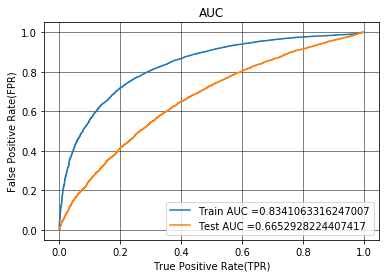

In [26]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

from sklearn.metrics import roc_curve,roc_auc_score

nb_bow = MultinomialNB(alpha = 0.537,fit_prior=False,class_prior=[0.5,0.5])

nb_bow.fit(X_tr, y_train)

y_train_pred_prob = predict_probability(nb_bow, X_tr)    
y_test_pred_prob = predict_probability(nb_bow, X_te)



#Print Area Under Curve Scores(AUC Scores)

nb_auc_train = roc_auc_score(y_train,y_train_pred_prob)
nb_auc_test = roc_auc_score(y_test,y_test_pred_prob)
print("AUC Score Train Data :",nb_auc_train)
print("AUC Score Test Data :",nb_auc_test)

#Plot ROC Curve
# roc_curve(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
#If AUC curve if going through middle og grid then its dumb model.

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_prob)


test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_prob)


plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

# Confusion Matrix (Set2)

In [27]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [28]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_prob, best_t)))
print("Test confusion matrix")
Confusion_Matrix_Test_Data = confusion_matrix(y_test, predict_with_best_t(y_test_pred_prob, best_t))
print(Confusion_Matrix_Test_Data)#Need predicted values as 2nd parameter not probability values

the maximum value of tpr*(1-fpr) 0.577817264020116 for threshold 0.668
Train confusion matrix
[[ 4158  1207]
 [ 7159 20976]]
Test confusion matrix
[[ 1351  1291]
 [ 3853 10005]]


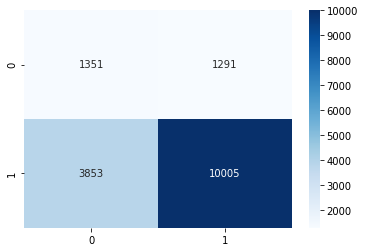

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt     

#annot -If True, write the data value in each cell
#fmt - String formatting code to use when adding annotations.If fmt is not there values come in expoential form(e)
sns.heatmap(Confusion_Matrix_Test_Data, annot=True,fmt ='d',cmap='Blues')


# Select best 20 features of both Positive and negative class for Set1

In [30]:
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow,X_train_teacher_prefix_bow,X_train_project_grade_category_bow,X_train_school_state_bow,X_train_clean_categories_bow,X_train_clean_subcategories_bow,X_train_price_norm_reshape,X_train_teacher_number_of_previously_posted_projects_norm_reshape)).tocsr()
X_te = hstack((X_test_essay_bow,X_test_teacher_prefix_bow,X_test_project_grade_category_bow,X_test_school_state_bow,X_test_clean_categories_bow,X_test_clean_subcategories_bow,X_test_price_norm_reshape,X_test_teacher_number_of_previously_posted_projects_norm_reshape)).tocsr()


print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 50101) (33500,)
(16500, 50101) (16500,)


In [31]:
nb_bow = MultinomialNB(alpha = 0.5,fit_prior=False,class_prior=[0.5,0.5])

nb_bow.fit(X_tr, y_train)

MultinomialNB(alpha=0.5, class_prior=[0.5, 0.5])

In [32]:
# Collecting feature names for set1

bow_features_names = []

for name in vectorizer_essay_bow.get_feature_names() :
    bow_features_names.append(name)
print(len(bow_features_names))      

for name in vectorizer_teacher_prefix.get_feature_names() :
    bow_features_names.append(name)
print(len(bow_features_names))

for name in vectorizer_grade.get_feature_names() :
    bow_features_names.append(name)
print(len(bow_features_names))

for name in vectorizer_state.get_feature_names() :
    bow_features_names.append(name)
print(len(bow_features_names))    

for name in vectorizer_clean_categories.get_feature_names() :
    bow_features_names.append(name)
print(len(bow_features_names))      

for name in vectorizer_clean_subcategories.get_feature_names() :
    bow_features_names.append(name)
print(len(bow_features_names))     

50000
50005
50009
50060
50069
50099


In [33]:
bow_features_names.append('price')
bow_features_names.append('teacher_number_of_previously_posted_projects')
print(len(bow_features_names))  

50101


# NOTE
Using argsort by default it sorts in ascending order,but we need sorted log probabilities in desc order.

In [34]:
#Prints log probabilities of both class
print(nb_bow.feature_log_prob_)
print(nb_bow.feature_log_prob_.shape)

[[-10.87815616 -10.3273252  -11.2734689  ... -14.76997646  -5.48908443
   -5.9241992 ]
 [-11.44453234 -10.23860067 -11.22269684 ... -15.37635798  -5.53703568
   -5.90209046]]
(2, 50101)


In [35]:
#Sorts and prints indexes of log probabilities in matrix in ascending order for both class
print(np.argsort(nb_bow.feature_log_prob_))

[[42452 43241 37516 ... 22054 34832 38845]
 [50098 50061 50070 ... 26681 34832 38845]]


In [36]:
#Prints log probability indices for only Negative Class
print(np.argsort(nb_bow.feature_log_prob_)[0])

[42452 43241 37516 ... 22054 34832 38845]


In [37]:
#Sorts in Descending order
print(np.argsort(nb_bow.feature_log_prob_)[0][::-1])

[38845 34832 22054 ... 37516 43241 42452]


# Top 20 Features - Negative

In [38]:

max_ind_neg=np.argsort((nb_bow.feature_log_prob_)[0])[::-1][0:20]

In [39]:
#np.take gets the feature names using the sorted indices stored in max_ind_neg
print(np.take(bow_features_names,max_ind_neg))

['students' 'school' 'learning' 'my' 'classroom' 'not' 'learn' 'they'
 'help' 'the' 'my students' 'price' 'many' 'nannan' 'we' 'work' 'need'
 'come' 'year' 'able']


# Top 20 Features - Positve

In [40]:
max_ind_pos=np.argsort((nb_bow.feature_log_prob_)[1])[::-1][0:20]

In [41]:
print(np.take(bow_features_names,max_ind_pos))

['students' 'school' 'my' 'learning' 'classroom' 'the' 'not' 'they'
 'learn' 'my students' 'help' 'price' 'many' 'nannan' 'work' 'we'
 'reading' 'need' 'use' 'day']


In [42]:

# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Alpha:Hyper Parameter", " Test AUC"]

x.add_row(["BOW", "Naive Bayes", 0.5, 0.69])
x.add_row(["TFIDF", "Naive Bayes", 0.537, 0.67])

print(x)

+------------+-------------+-----------------------+-----------+
| Vectorizer |    Model    | Alpha:Hyper Parameter |  Test AUC |
+------------+-------------+-----------------------+-----------+
|    BOW     | Naive Bayes |          0.5          |    0.69   |
|   TFIDF    | Naive Bayes |         0.537         |    0.67   |
+------------+-------------+-----------------------+-----------+


# We can conclude that Naive Bayes Model applied on BOW Vectorizer gave better AUC than TFIDF Vectorizer